In [1]:
#Import the necessary Python moduless
import glob, os

import json 
import numpy as np
import pandas as pd

import geopandas as gpd
from geopandas.tools import sjoin
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
import shapely
from shapely.geometry import Point
import unicodedata
import pysal as ps

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)

# 1. Data loading 

## 1.1 Load GIS data

In [2]:
import requests, zipfile, io

def get_shp_fnames(zip_file_url, data_dirr):
    """
    Get a list of names of shp files from a zip file at a zip_file_url
    Extract zip files a local directory defined by "data_dirr"
    e.g. zip_file_url = 'https://data.humdata.org/dataset/d2ec62bb-5a93-436d-8297-88b3ee9b6818
                        /resource/186a227b-6e9c-4b90-8634-b6369da07e17/download/mli_adm_1m_dnct_2019_shp.zip'
         data_dirr ='../data/GIS/'
          output:
          ['mli_admbnda_adm0_1m_dnct_20190802.shp',
           'mli_admbnda_adm1_1m_dnct_20190802.shp',
           'mli_admbnda_adm2_1m_dnct_20190802.shp',
           'mli_admbnda_adm3_1m_dnct_20190802.shp',
           'mli_admbndl_admALL_1m_dnct_itos_20190802.shp']
    """
    
    r = requests.get(zip_file_url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=data_dirr)
    shp_fnames = [i for i in z.namelist() if i.endswith(".shp")]
    return shp_fnames

In [3]:
amd_zip_file_url = "https://data.humdata.org/dataset/d2ec62bb-5a93-436d-8297-88b3ee9b6818\
/resource/186a227b-6e9c-4b90-8634-b6369da07e17/download/mli_adm_1m_dnct_2019_shp.zip"
data_dirr = '../data/GIS/mli_adm_1m_dnct_2019_shp/'

adm_shp_fnames = get_shp_fnames(amd_zip_file_url, data_dirr)

In [4]:
adm_shp_fnames

['mli_admbnda_adm0_1m_dnct_20190802.shp',
 'mli_admbnda_adm1_1m_dnct_20190802.shp',
 'mli_admbnda_adm2_1m_dnct_20190802.shp',
 'mli_admbnda_adm3_1m_dnct_20190802.shp',
 'mli_admbndl_admALL_1m_dnct_itos_20190802.shp']

In [5]:
# read in shp files 
gis_adm0 = gpd.read_file(data_dirr+adm_shp_fnames[0])
gis_adm1 = gpd.read_file(data_dirr+adm_shp_fnames[1])
gis_adm2 = gpd.read_file(data_dirr+adm_shp_fnames[2])
gis_adm3 = gpd.read_file(data_dirr+adm_shp_fnames[3])

## 1.2 Load population data

In [6]:
# download population data
def csv_from_url(url):
    """
    Read a csv file from an url into datafram format. Drop extra columns. 
    """
    df = pd.read_csv(url).dropna(axis =1, how='all').dropna(axis =0, how='all')
    return df

In [57]:
adm0_url = 'https://data.humdata.org/dataset/ce21c7db-d8f0-40f8-adc2-452d2d2d105c/resource/6f243ba2-4d4a-4663-a7c4-e917dbbde73a/download/mli_pop_adm0.csv'
adm1_url = 'https://data.humdata.org/dataset/ce21c7db-d8f0-40f8-adc2-452d2d2d105c/resource/0bd515ae-613c-400f-a84c-ea203cc529be/download/mli_pop_adm1.csv'
adm2_url = 'https://data.humdata.org/dataset/ce21c7db-d8f0-40f8-adc2-452d2d2d105c/resource/af0c935f-d507-4252-945c-9d1a6cc1b598/download/mli_pop_adm2.csv'
adm3_url = 'https://data.humdata.org/dataset/ce21c7db-d8f0-40f8-adc2-452d2d2d105c/resource/6a73b827-302d-47be-94a9-580fa73011b5/download/mli_pop_adm3.csv'

pop_adm0 = csv_from_url(adm0_url)
pop_adm1 = csv_from_url(adm1_url)
pop_adm2 = csv_from_url(adm2_url)
pop_adm3 = csv_from_url(adm3_url)

In [87]:
pop_adm3.shape

(701, 14)

## 1.3 Load health data

In [8]:
health_zip_file_url ="https://data.humdata.org/dataset/a512111d-9b60-4b8c-9b24-24a64da1506b/resource/b3074e99-2928-4f12-aeef-decd78b2c509/download/mali-shapefiles.zip"
data_dirr_h = '../data/GIS/mali-shapefiles/'
healthsite_shp_fnames =get_shp_fnames(health_zip_file_url,data_dirr_h)
gis_healthsites =gpd.read_file(data_dirr_h+healthsite_shp_fnames[0])

In [68]:
gis_healthsites.iloc[:3,20:]

,changese_1,emergency,changese_2,addr_house,addr_postc,addr_city,name,staff_nurs,changese_3,wheelchair,beds,url,dispensing,healthcare,operator_t,geometry
0,2,None,2014-11-19,None,None,None,Centre de Santé Communautaire de Banindo,None,jgc,yes,None,None,None,None,None,POINT (-6.84013 12.87360)
1,2,None,2018-07-03,None,None,None,SISSMED Santé,None,Nathalie SIDIBE,None,None,None,None,None,None,POINT (-8.03288 12.64399)
2,1,None,2020-11-18,None,None,None,centre de santé,None,MamaTraoré,None,None,None,None,hospital,None,POINT (-5.53963 13.09694)


## 1.4 Load settlement data

In [29]:
settlements_zip_file_url = 'https://data.humdata.org/dataset/1542b2e2-ffd1-4835-bc6f-a9e6dcf7421d/resource/bb63df0b-9485-4c88-90b6-3009e6fd072e/download/mli_populatedplaces_shp.zip'
data_dirr_settlement = '../data/GIS/mli_populatedplaces_shp/'
settlement_shp_fnames =get_shp_fnames(settlements_zip_file_url, data_dirr_settlement)
gis_settlement =gpd.read_file(data_dirr_settlement+settlement_shp_fnames[0])

In [30]:
gis_settlement.head(3)

,featureNam,pcode,featureRef,featureAlt,featureA_1,popPlaceCl,popPlace_1,admin0Name,admin0Pcod,admin1Name,admin1Pcod,admin2Name,admin2Pcod,admin3Name,admin3Pcod,date,validOn,validTo,geometry
0,Bambela,ML010101001,Bambela,None,None,5,None,Mali,ML,Kayes,ML01,Kayes,ML0101,Bangassi,ML010101,2015-02-02,2015-04-24,None,POINT (-11.57371 14.63110)
1,Bangassi-Doudou,ML010101002,Bangassi-Doudou,None,None,5,None,Mali,ML,Kayes,ML01,Kayes,ML0101,Bangassi,ML010101,2015-02-02,2015-04-24,None,POINT (-11.48828 14.53852)
2,Bangassi-Doudou-Maure,ML010101003,Bangassi-Doudou-Maure,None,None,5,None,Mali,ML,Kayes,ML01,Kayes,ML0101,Bangassi,ML010101,2015-02-02,2015-04-24,None,POINT (-11.48811 14.54539)


## 1.5 Load road data -- only has Bamako's data 

In [33]:
road_zip_file_url = 'https://data.humdata.org/dataset/f24cd828-1d81-427f-9f5a-c569f781b3a4/resource/bedfeb3e-0d82-41be-a394-fbe3688837d8/download/mali_bamako_road_network.zip'
data_dirr_road = '../data/GIS/Mali_Bamako_Road_Network/'
road_shp_fnames =get_shp_fnames(road_zip_file_url, data_dirr_road)
gis_road =gpd.read_file(data_dirr_road+road_shp_fnames[0])

In [34]:
gis_road.head(3)

,OBJECTID,nam,COMMENTS,SHAPE_STLe,geometry
0,1,Route de l'Aeroport,BAMAKO,0.061292,"LINESTRING Z (-7.94830 12.54048 0.00000, -7.94..."
1,2,UNK,BAMAKO,0.029022,"LINESTRING Z (-7.95113 12.54568 0.00000, -7.95..."
2,3,RN7,BAMAKO,0.089399,"LINESTRING Z (-7.91863 12.55985 0.00000, -7.91..."


# 2. Clean & munge data

In [9]:
## data cleaning 

# rename the columns to make them align. using gis as the stardard 

name_dict = {'admin0Name_fr':'ADM0_FR', 'admin0Pcode':'ADM0_PCODE',
             'admin1Name_fr':'ADM1_FR', 'admin1Pcode':'ADM1_PCODE',
             'admin2Name_fr':'ADM2_FR', 'admin2Pcode':'ADM2_PCODE',
             'admin3Name_fr':'ADM3_FR', 'admin3Pcode':'ADM3_PCODE'}
pop_adm0.rename(columns = name_dict, inplace=True)
pop_adm1.rename(columns = name_dict, inplace=True)
pop_adm2.rename(columns = name_dict, inplace=True)
pop_adm3.rename(columns = name_dict, inplace=True)


In [10]:
# gis_adm3 have columns named differently. Rename the columns 
gis_name_dict = {'admin0Name':'ADM0_FR', 'admin0Pcod':'ADM0_PCODE',
             'admin1Name':'ADM1_FR', 'admin1Pcod':'ADM1_PCODE',
             'admin2Name':'ADM2_FR', 'admin2Pcod':'ADM2_PCODE',
             'admin3Name':'ADM3_FR', 'admin3Pcod':'ADM3_PCODE'}
gis_adm3.rename(columns =gis_name_dict ,inplace=True)

In [11]:
# merge population data with GIS data

adm0_cols_to_use = list(pop_adm0.columns.difference(gis_adm0.columns)) + ['ADM0_FR']
adm1_cols_to_use = list(pop_adm1.columns.difference(gis_adm1.columns)) + ['ADM1_PCODE']
adm2_cols_to_use = list(pop_adm2.columns.difference(gis_adm2.columns)) + ['ADM2_PCODE']
adm3_cols_to_use = list(pop_adm3.columns.difference(gis_adm3.columns)) + ['ADM3_PCODE']

adm0_df = gis_adm0.merge(pop_adm0[adm0_cols_to_use], on = 'ADM0_FR')
adm1_df = gis_adm1.merge(pop_adm1[adm1_cols_to_use], on = 'ADM1_PCODE')
adm2_df = gis_adm2.merge(pop_adm2[adm2_cols_to_use], on = 'ADM2_PCODE')
adm3_df = gis_adm3.merge(pop_adm3[adm3_cols_to_use], on = 'ADM3_PCODE')

## 3. Plotting

### 3.1 Geopandas

<IPython.core.display.Javascript object>


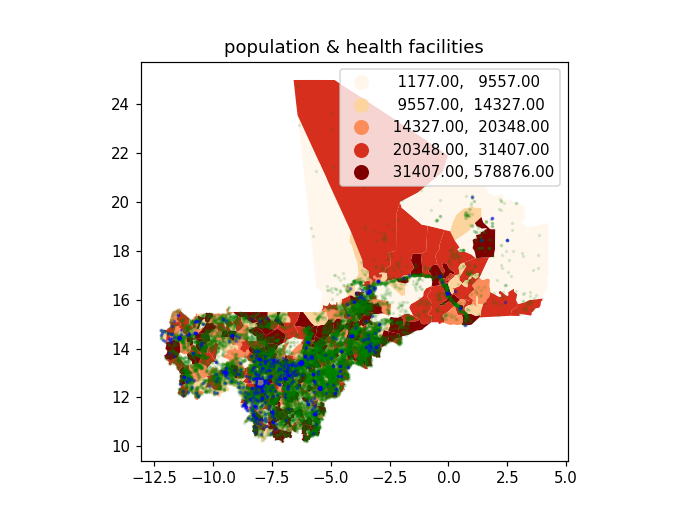

Text(0.5, 1.0, 'population & health facilities')

In [53]:
%matplotlib notebook
base = adm3_df.plot(column='Ensemble',legend=True, cmap='OrRd', scheme='quantiles')
gis_settlement.plot(color='green',markersize=2, ax =base, alpha = 0.1)
gis_road.plot(color='grey',markersize=2, ax =base, alpha = 0.3)
gis_healthsites.plot(color='blue',markersize=2, ax =base, alpha = 0.3)

plt.title('population & health facilities')

### 3.2 Folium

In [13]:
# convert to geojson 
adm1_gj = json.loads(adm1_df.to_crs(epsg='4326').to_json())
adm2_gj = json.loads(adm2_df.to_crs(epsg='4326').to_json())
adm3_gj = json.loads(adm3_df.to_crs(epsg='4326').to_json())

In [14]:
m = folium.Map(location=[17.89305884201745, -1.7063720462619767], zoom_start=5)
adm1_geojson = folium.features.GeoJson(adm1_gj)
adm2_geojson = folium.features.GeoJson(adm2_gj)
adm3_geojson = folium.features.GeoJson(adm3_gj)
m.add_child(adm1_geojson)
#m.add_child(adm2_geojson)
#m.add_child(adm3_geojson)

# add population information 
choropleth = folium.Choropleth(adm1_gj,
                  fill_color='YlGn-1',
                  fill_opacity=0.2,
                  line_opacity=0,
                  legend_name='population',
).add_to(m)

# display population when hover the mouse over
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['ADM1_FR','Ensemble','Féminin','Masculin'])
)

m